In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3

In [6]:
data_dir = './images2/'
img_size = 300
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 50968 files belonging to 149 classes.
Using 40775 files for training.
Found 50968 files belonging to 149 classes.
Using 10193 files for validation.


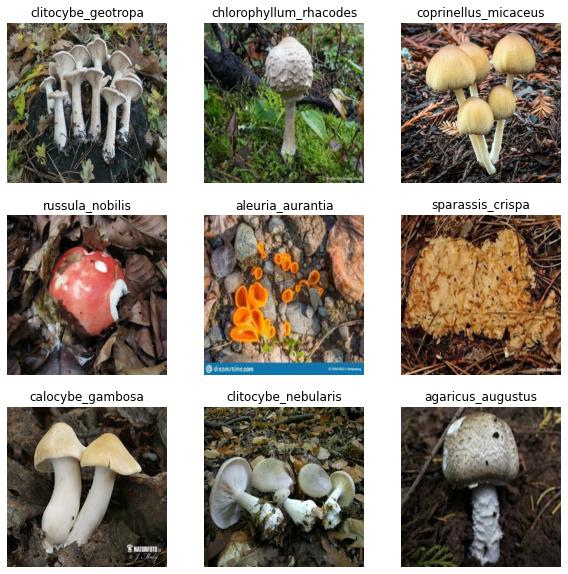

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
def build_model():

    base_model = EfficientNetB3(weights=None, include_top=False)

    base_model.trainable = False

    image_batch, label_batch = next(iter(train_ds))

    feature_batch = base_model(image_batch)

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    feature_batch_average = global_average_layer(feature_batch)

    prediction_layer = tf.keras.layers.Dense(num_classes, 
                                             kernel_regularizer=tf.keras.regularizers.l2(0.001))

    prediction_batch = prediction_layer(feature_batch_average)

    inputs = tf.keras.Input(shape=(img_size, img_size, 3))

    x = base_model(inputs, training=False)

    x = global_average_layer(x)

    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = prediction_layer(x)

    model = tf.keras.Model(inputs, outputs)
    
    return model

In [8]:
model = build_model()

In [9]:
checkpoint_path = 'C:\\Users\\danie\\Downloads\\results\\checkpoints'
latest = tf.train.latest_checkpoint(checkpoint_path)
print(latest)

C:\Users\danie\Downloads\results\checkpoints\test_save_weights


In [10]:
model.load_weights(latest)

In [ ]:
val_confusion = np.zeros((num_classes, num_classes))

for images, labels in val_ds.take(10):

    val_confusion += tf.math.confusion_matrix(labels=labels, 
                                  predictions=model.predict(images).argmax(axis=1), 
                                  num_classes=num_classes)        

In [1]:
plot_confusion_matrix(val_confusion)

NameError: name 'plot_confusion_matrix' is not defined

In [22]:
def plot_confusion_matrix(confusion, save_file=None):

    conf_norm = [100 * row / np.sum(row) for row in confusion]
    
    names = [class_name.replace('_', ' ').title() for class_name in class_names]

    plt.figure(figsize=(18, 10))
    _ = plt.imshow(conf_norm, cmap='YlOrBr', vmin=0, vmax=100)

    plt.ylabel('True label', size=18); plt.xlabel('Predicted label', size=18)
    
    np.save(arr=conf_norm, file=checkpoint_path + '/confusion')

#     plt.xticks(np.arange(num_classes), names, size = 14, rotation=90)
#     plt.yticks(np.arange(num_classes), names, size = 14)

#     for (j,i), label in np.ndenumerate(conf_norm):
#         percentage = 'f{label:.2f}%'
#         plt.text(i, j, percentage, ha='center', va='center', size=14)

#     if save_file:
#         plt.savefig(f'{checkpoint_path}\\{save_file}.jpg', bbox_inches='tight', dpi=100)
#         plt.title(save_file.replace('_', ' ').title(), size=22);


In [ ]:
# plot_confusion_matrix(confusion=train_confusion, save_file='confusion_train')

In [ ]:
# plot_confusion_matrix(confusion=val_confusion, save_file='confusion_val')

In [ ]:
# could use latest effnet:
# https://github.com/google/automl/blob/master/efficientnetv2/tutorial.ipynb